# **Prediction** Notebook

### Installing Libraries

In [ ]:
!pip install -U segmentation-models==1.0
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install tensorflow==2.2.0
!pip install keras==2.3.1

### Importing dependencies

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import segmentation_models as sm
import albumentations as A
import tensorflow as tf
import keras

### Downloading and unzipping Test data

In [ ]:
! wget --header="Host: doc-34-14-drive-data-export.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-IN;q=0.9,en-US;q=0.8,en;q=0.7" --header="Cookie: AUTH_inospmqgbhcnbl1h7bg3s0l93hj88bu9_nonce=rm5q15t7po534; cX_P=kenu4myncvcloryt; cX_G=cx%3A14zcwnzumfin835hawih1zfya2%3A1xnwghsyk9wci" --header="Connection: keep-alive" "https://doc-34-14-drive-data-export.googleusercontent.com/download/eth4r15ck6qoqlp5ags1fenni8enkofb/emtf3vib6ldq0l7ievb90uoaklfb0560/1617457500000/79590eec-c30a-4117-93f6-594b9f3a3cba/100090168314792971977/ADt3v-P1v98eZ76Me9yrHP5g_YOzuoWdaFpkFeiZ9LAkCSTNcEeEy9pHHRTGD5eX8bWyCZNe0ywYmepWAuObrM6CqGrLw1_SzhML8TRp-Y-r9-o94OKeRifaZd1_rlQMkegorxuefY7dKnRhftKO5Pzy2K7Y-GI9ksw0NM_Phkmp8QqadG7cOii8ZuEYFHyO2dRiZXzWCVrZwIqVBaSeVigmHJtWGwVSjz63b5c65B1iMcGbOSsPx4xsI502ee_eeHTfEJyeg_7UAuIUprfh0Ath1VaX5Bt71sDo6GrqJDHvAWf9J7ErlA-TwUysWSc6htFnn6JOElai?authuser=2&nonce=rm5q15t7po534&user=100090168314792971977&hash=2i0tsseh3q1q68fbacrcpgvkqti4nn88" -c -O 'test-20210403T142209Z-001.zip'

!unzip "/content/test-20210403T142209Z-001.zip" -d "/content/sample_data";

### Creating DataLoaders

In [9]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset2:
    
    CLASSES = ['Barren Land', 'Vegetation', 'road_kaccha', 'Green Farm', 'Dry Farm', 'road_pakka', 'Water Body', 'Building', 'Others']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids =(images_dir)
        self.images_fps = [image_id for image_id in self.ids]
        self.masks_fps = [image_id for image_id in masks_dir]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(2048,1920),interpolation=cv2.INTER_AREA)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask=cv2.resize(mask,(2048,1920),interpolation=cv2.INTER_AREA)
        # extract certain classes from mask 
        masks = [(mask == 255) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
 
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

### Image Pre-processing

In [7]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

### Preprocessed test images according to the model used

Test images input for efficientnet b1 models

In [10]:
CLASSES = ['Vegetation']
test_dataset_eb1 = Dataset2(
    submission['ImageId'],submission['ImageId'],
    classes=CLASSES, 
    preprocessing=get_preprocessing(sm.get_preprocessing('efficientnetb1')),

)

test_dataloadereb1 = Dataloder(test_dataseteb1, batch_size=1, shuffle=False)

[1]


Test images input for Resnet 34 models

In [11]:
CLASSES = ['Vegetation']
test_dataset_res = Dataset2(
    submission['ImageId'],submission['ImageId'],
    classes=CLASSES, 
    preprocessing=get_preprocessing(sm.get_preprocessing('resnet34')),

)

test_dataloader_res = Dataloder(test_dataset_res, batch_size=1, shuffle=False)

[1]


Test images input for Se-ResNext50 models

In [12]:
CLASSES = ['Vegetation']
test_dataset_se = Dataset2(
    submission['ImageId'],submission['ImageId'],
    classes=CLASSES, 
    preprocessing=get_preprocessing(sm.get_preprocessing('seresnext50')),

)

test_dataloader_se = Dataloder(test_dataset_se, batch_size=1, shuffle=False)

[1]


## Models

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we load the weights of the individually trained models to use it for final ensmebling.

The individual base models are ->

1. Unet + Efficient net B1 with Decoder filters (256,128,64,32,8)
2. Unet + SeResNext50
3. Unet + Efficient net B1 with Transposed Convolutions in Decoder Block
4. Unet + Efficient net B1 trained on Random crops of 256 x 256 sized patches on training dataset
5. Unet + Resnet 34 trained on Random crops of 224 x 224 sized patches on training dataset

In [5]:
Eff_Net_B1_Filter = sm.Unet('efficientnetb1', classes=1,weights='/content/drive/MyDrive/weights/modeleffb1filter.h5', activation='sigmoid',decoder_filters=(256, 128, 64, 32, 8))

Se_resnext_50 = sm.Unet('seresnext50', classes=1,weights='/content/drive/MyDrive/weights/modeleseresnet50.h5', activation='sigmoid')

Eff_Net_B1_Trans= sm.Unet('efficientnetb1', classes=1,weights='/content/drive/MyDrive/weights/modelefffb1trans.h5', activation='sigmoid',decoder_block_type='transpose')

Eff_Net_Rcrop_256=sm.Unet('efficientnetb1', classes=1,weights='/content/drive/MyDrive/weights/unetb1randomcrop256.h5', activation='sigmoid')

Resnet_34_Rcrop_224=sm.Unet('resnet34', classes=1,weights='/content/drive/MyDrive/weights/resnet34-228TT.h5', activation='sigmoid')


# Prediction !

Now that we have loaded the test data and the individual models, let us predict on the test dataset.

In [ ]:
submission=pd.read_csv('/content/sample_data/Sample Submission.csv') # Loading the submission file

In [ ]:
submission.head()

ImageId EncodedPixels
0        TN_632663_12.17698923_79.74434127_18.png           1 1
1         TN_632269_12.4309812_79.29519495_18.png           1 1
2        TN_632589_12.22150005_79.86395921_18.png           1 1
3        TN_632406_12.25225177_79.47212711_18.png           1 1
4  TN_632592_12.17579518_79.89499740000002_18.png           1 1

Steps for  prediction ->

1. Load the images from data loader
2. Expand the dimension along axis=0 , i.e creating batch_size=1
3. Now using model.predict for prediction
4. The prediction array is of shape 1920 x 2048, thus resizing it back to 1948 x 2048
5. Rounding the probabilities to 0 or 1.
6. Appending the prediction of each image in a list
7. Repeat the above steps for each model.

Model_1. Unet + Efficient net B1 with Decoder filters (256,128,64,32,8)

In [ ]:
ids =submission['ImageId']
prob=[]
proba=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_eb1[i]                             
    image = np.expand_dims(image, axis=0)
    pr_mask = Eff_Net_B1_Filter.predict(image)
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    proba.append(pr_mask)
    pr_mask=pr_mask.round()
    prob.extend(pr_mask)

prob1=prob  

Model_2. Unet + SeResNext50

In [ ]:
ids =submission['ImageId']
prob=[]
proba=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_se[i]                             
    image = np.expand_dims(image, axis=0)
    pr_mask = Se_resnext_50.predict(image)
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    proba.append(pr_mask)
    pr_mask=pr_mask.round()
    prob.extend(pr_mask)

prob2=sprob

Model_3. Unet + Efficient net B1 with Transposed Convolutions in Decoder Block

In [ ]:
ids =submission['ImageId']
prob=[]
proba=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_eb1[i]                             
    image = np.expand_dims(image, axis=0)
    pr_mask = Eff_Net_B1_Trans.predict(image)
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    proba.append(pr_mask)
    pr_mask=pr_mask.round()
    prob.extend(pr_mask)

prob3=prob

Model_4. Unet + Efficient net B1 trained on Random crops of 256 x 256 sized patches on training dataset

In [ ]:
ids =submission['ImageId']
prob=[]
proba=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_eb1[i]                             
    image = np.expand_dims(image, axis=0)
    pr_mask = Eff_Net_Rcrop_256.predict(image)
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    proba.append(pr_mask)
    pr_mask=pr_mask.round()
    prob.extend(pr_mask)

prob4=prob

Model_5. Unet + Resnet 34 trained on Random crops of 224 x 224 sized patches on training dataset

In [ ]:
ids =submission['ImageId']
prob=[]
proba=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_res[i]                             
    image = np.expand_dims(image, axis=0)
    pr_mask = Resnet_34_Rcrop_224.predict(image)
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    proba.append(pr_mask)
    pr_mask=pr_mask.round()
    prob.extend(pr_mask)

prob5=prob

# Visualizing predictions of each model on test images

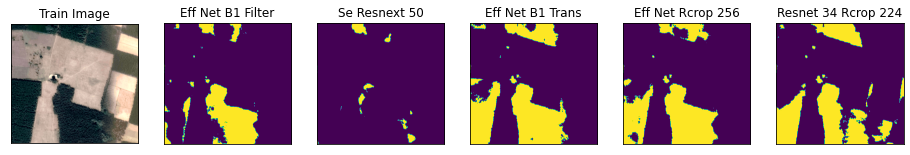

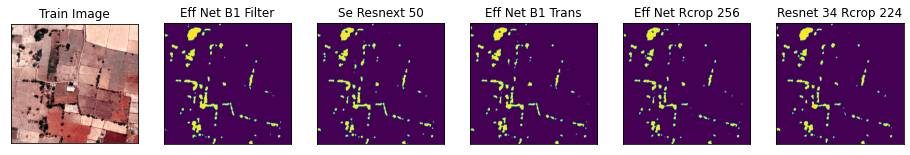

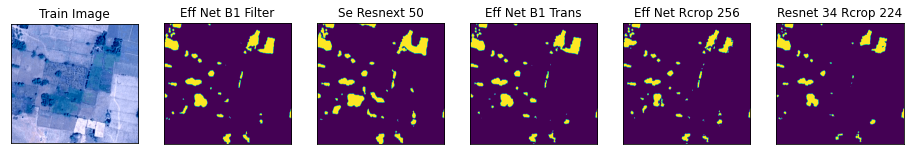

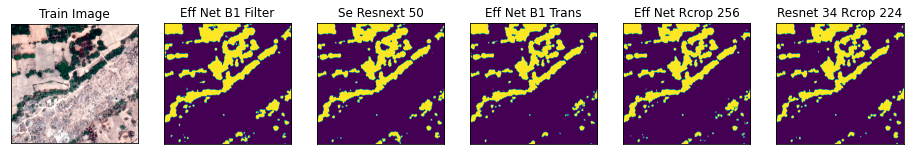

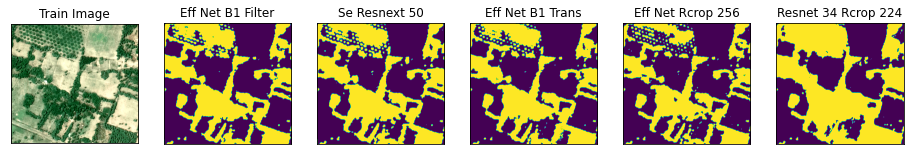

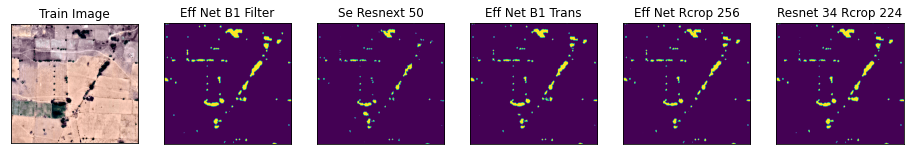

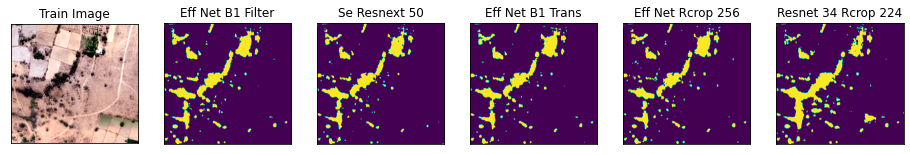

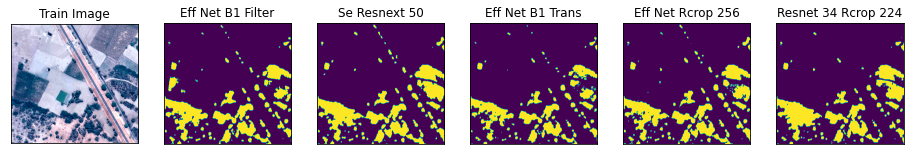

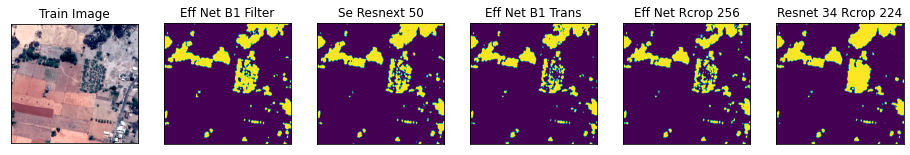

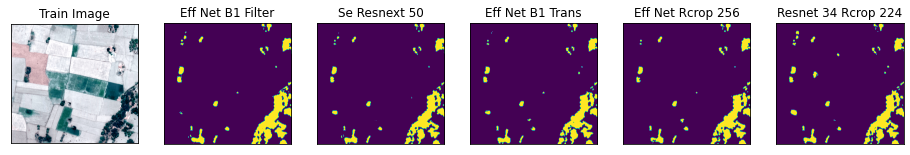

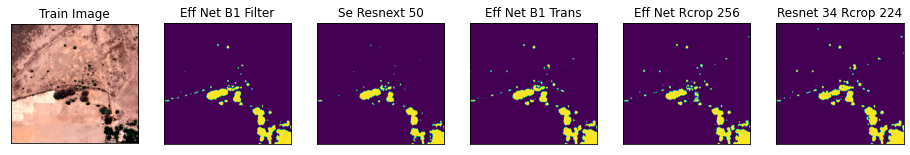

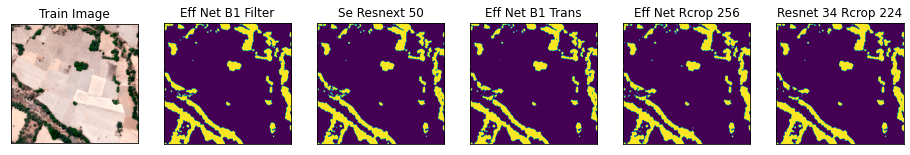

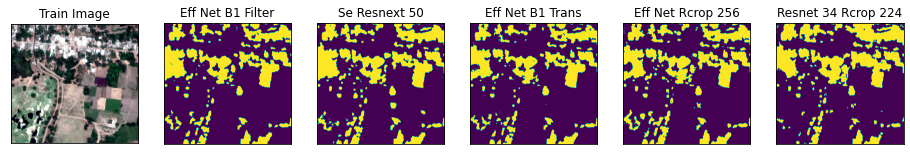

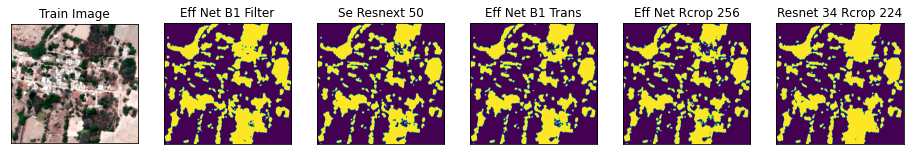

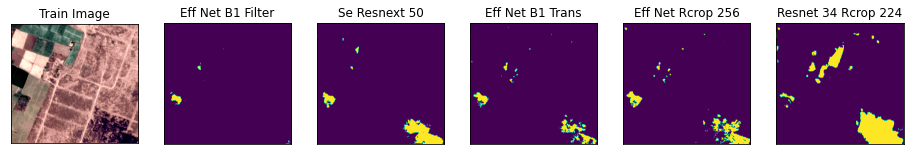

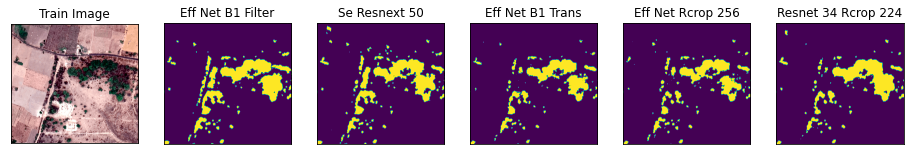

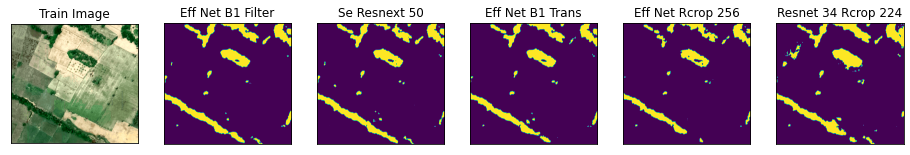

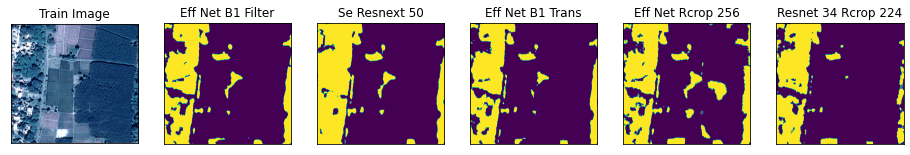

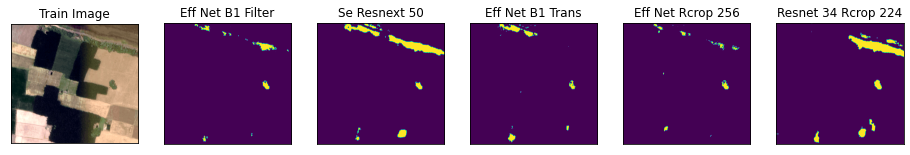

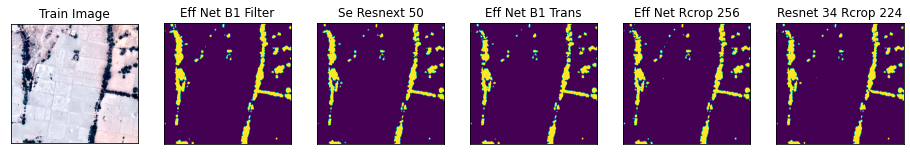

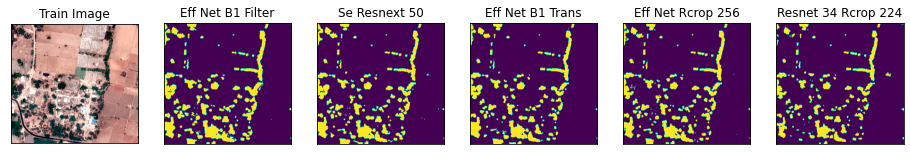

In [ ]:
n = 5
ids =submission['ImageId']
prob=[]
for i in range(len(ids)):
    
    image, gt_mask = test_dataset_se[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = Se_resnext_50.predict(image).round()
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    prob.extend(pr_mask)
    visualize(
        train_image=denormalize(image.squeeze()),
        Eff_Net_B1_Filter=prob1[i][..., 0].squeeze(),
        Se_resnext_50=pr_mask[..., 0].squeeze(),
        Eff_Net_B1_Trans=prob3[i][..., 0].squeeze(),
        Eff_Net_Rcrop_256=prob4[i][..., 0].squeeze(),
        Resnet_34_Rcrop_224=prob5[i][..., 0].squeeze(),

    )

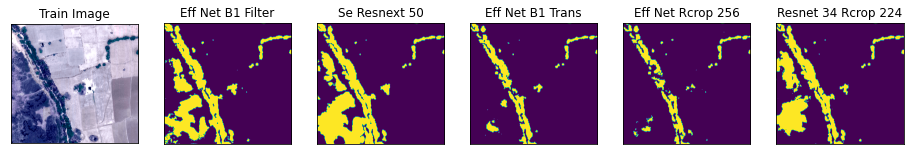

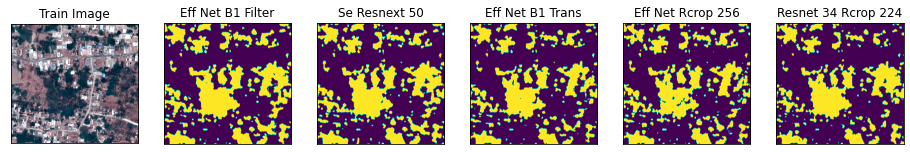

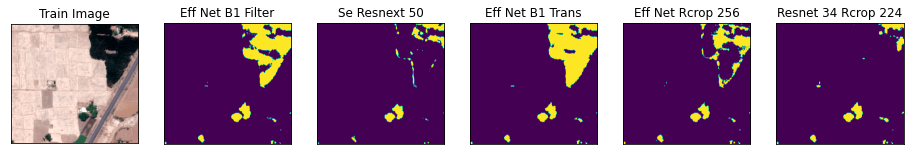

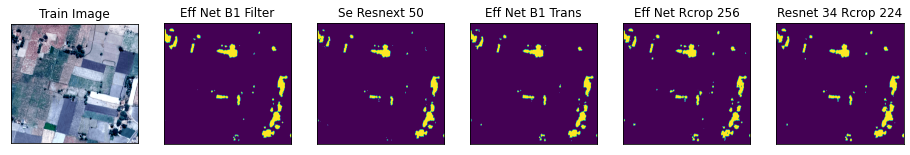

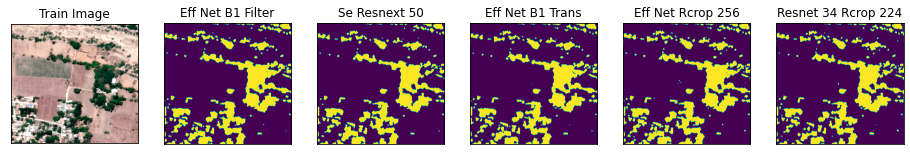

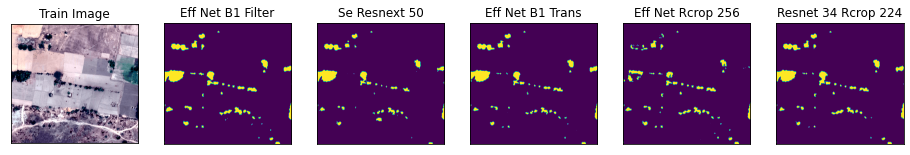

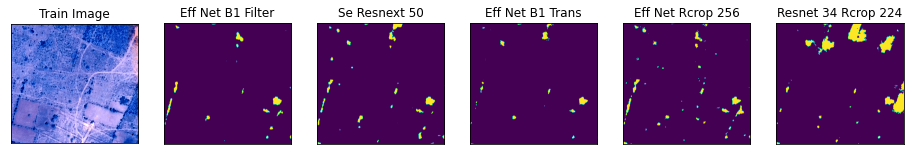

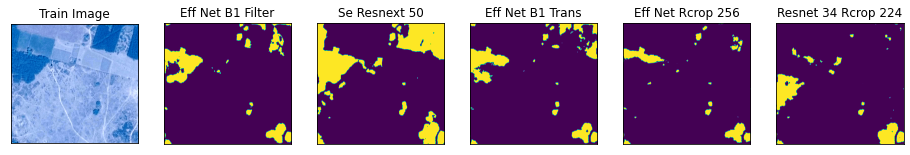

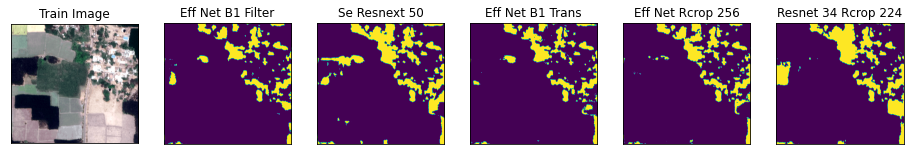

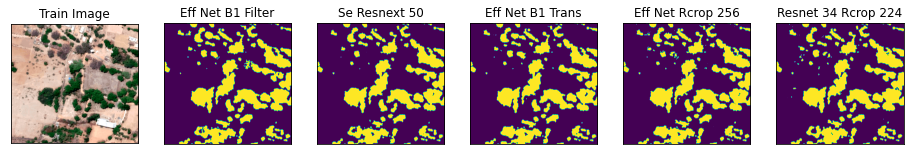

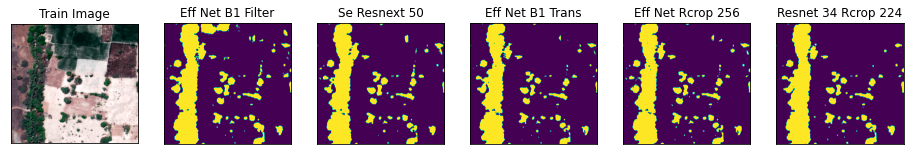

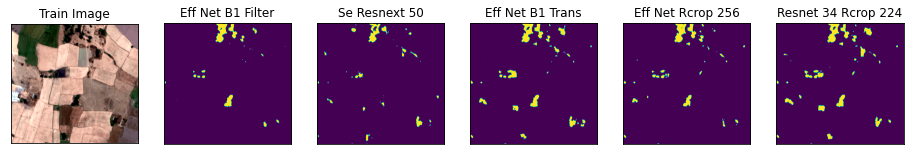

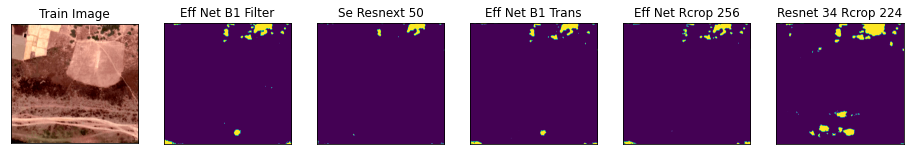

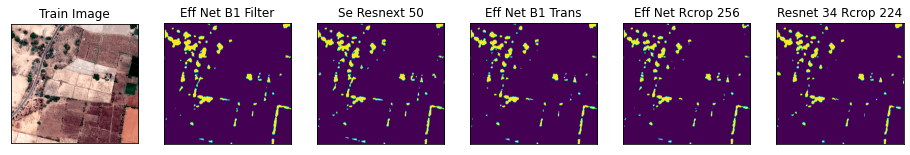

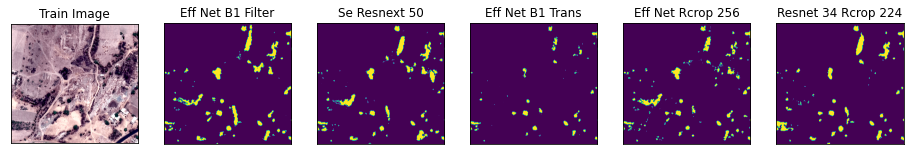

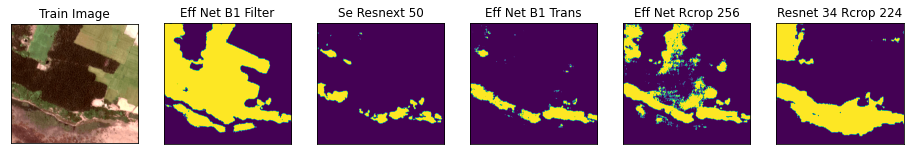

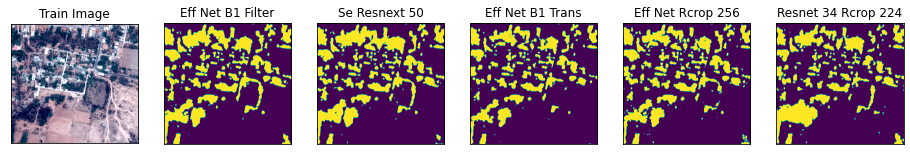

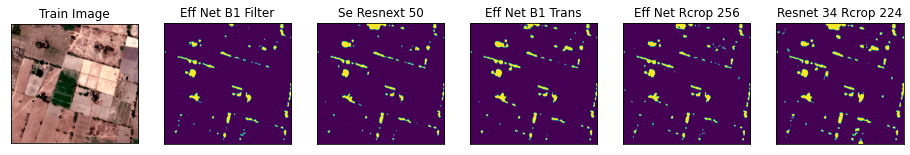

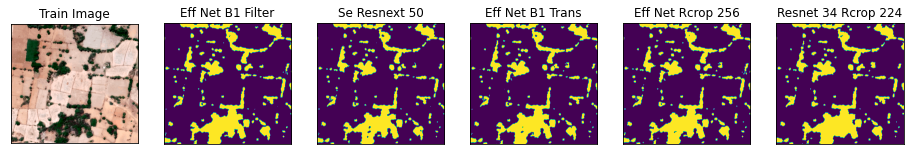

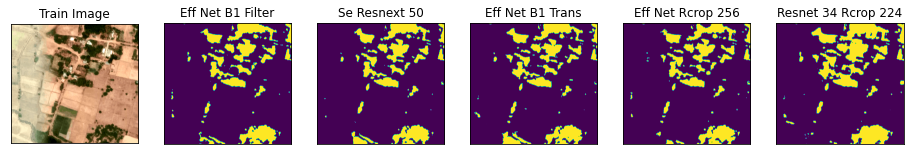

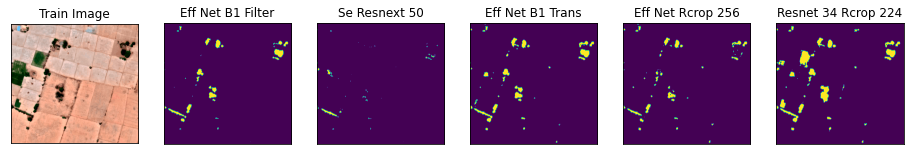

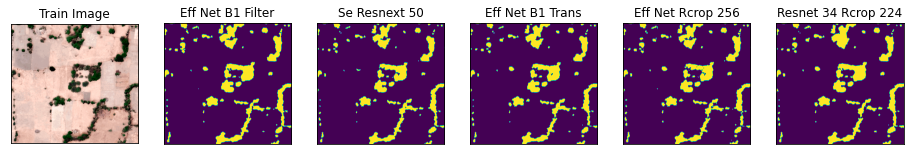

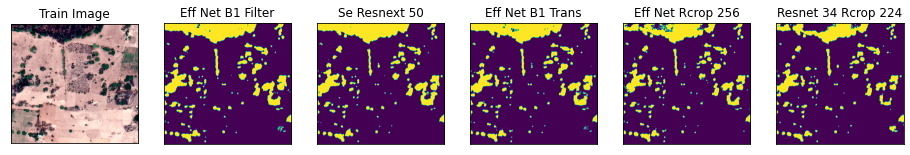

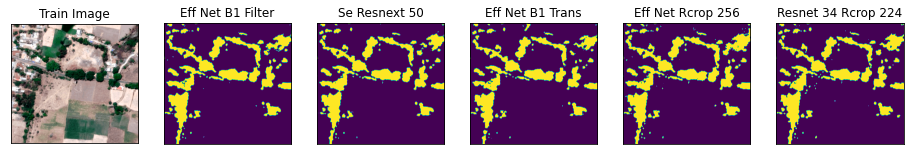

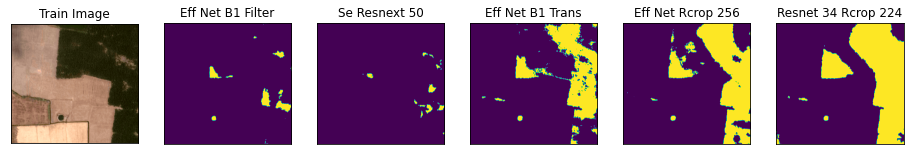

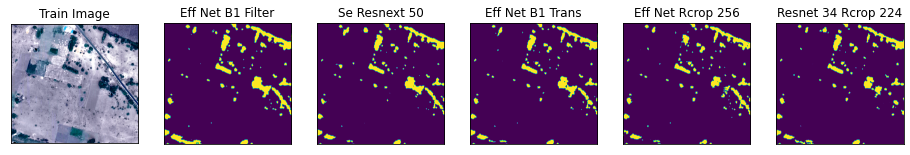

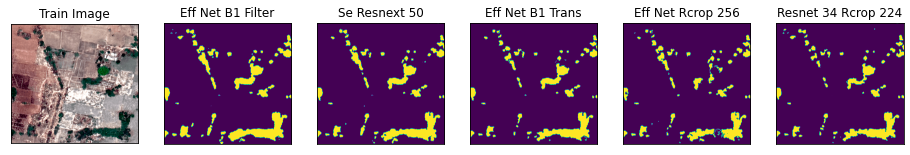

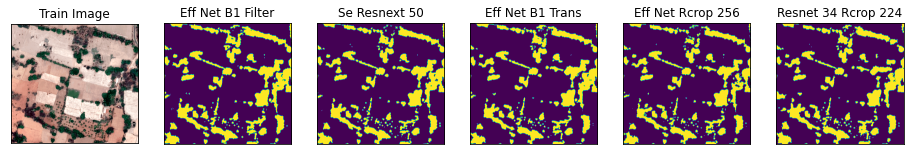

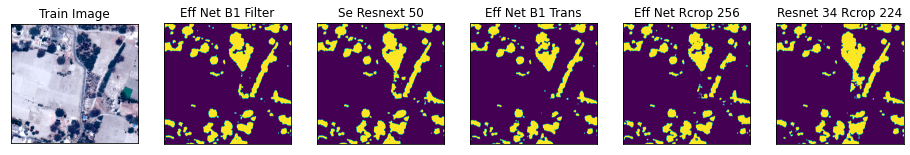

In [26]:
n = 5
ids =submission['ImageId']
prob=[]
for i in range(21,len(ids)):
    
    image, gt_mask = test_dataset_se[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = Se_resnext_50.predict(image).round()
    pr_mask=tf.image.resize(pr_mask, [1948, 2048]).numpy()
    prob.extend(pr_mask)
    visualize(
        train_image=denormalize(image.squeeze()),
        Eff_Net_B1_Filter=prob1[i][..., 0].squeeze(),
        Se_resnext_50=pr_mask[..., 0].squeeze(),
        Eff_Net_B1_Trans=prob3[i][..., 0].squeeze(),
        Eff_Net_Rcrop_256=prob4[i][..., 0].squeeze(),
        Resnet_34_Rcrop_224=prob5[i][..., 0].squeeze(),

    )

# Ensemble model for final prediction

We observed that since all models were pretty much consistent for most images, there were a few ambiguous cases where they differed in their predictions. Hence we decided to take a simple averaging ensemble.

In [ ]:
pred=[]
for i in range(50):
  pred.append(((prob1[i]+prob3[i]+prob4[i]+prob5[i])/4).round())

In [29]:
np.unique(pred)

array([0., 1.], dtype=float32)

## RLE Encoding and Submission

1.Generate run length encodings for each test prediction

2.Submission

In [15]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [70]:
new_test_ids = []
rles = []
for n, id_ in enumerate(submission['ImageId']):
    rle = rle_encoding(np.array(np.squeeze(pred[n].round(),axis=-1)))
    rles.append(rle)
    new_test_ids.extend([id_] * len(rle))
rleencode=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))    

In [72]:
submission['EncodedPixels']=rleencode

In [73]:
os.chdir('/content/sample_data')
submission.to_csv('filenew.csv',index=False)